In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imodelsx import embgam
from datasets import load_dataset
from sklearn.base import ClassifierMixin, RegressorMixin
import pandas as pd
from preprocess import clean_headlines, sample_data
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
def predict(model, X, warn=True):
    """For regression returns continuous output.
    For classification, returns discrete output.
    """
    preds = _predict_cached(model, X, warn=warn)
    if isinstance(model, RegressorMixin):
        return preds
    elif isinstance(model, ClassifierMixin):
        if preds.ndim > 1:  # multiclass classification
            return np.argmax(preds, axis=1)
        return ((preds + model.linear.intercept_) > 0).astype(int)


def _predict_cached(model, X, warn):
    """Predict only the cached coefs in model.coefs_dict_"""
    assert hasattr(model, "coefs_dict_"), "coefs are not cached!"
    preds = []
    n_unseen_ngrams = 0
    for x in X:
        pred = np.zeros(len(model.classes_))
        seqs = embgam.embed.generate_ngrams_list(
            x,
            ngrams=model.ngrams,
            tokenizer_ngrams=model.tokenizer_ngrams,
            all_ngrams=model.all_ngrams,
        )
        for seq in seqs:
            if seq in model.coefs_dict_:
                pred += model.coefs_dict_[seq]
            else:
                n_unseen_ngrams += 1
        preds.append(pred)

    return np.array(preds)

In [3]:
# load data
with open(f"Data/huffpost.pkl", "rb") as f:
    huffpost_data = pkl.load(f)

huffpost_data = clean_headlines(huffpost_data)
test_data, test_labels = sample_data(huffpost_data, year=2016, in_dist=False, frac=1)

# load model
mean_acc = []
std_acc = []
for frac in range(11):
    acc = []
    for seed in [42, 192, 852, 5555]:
        with open(f"models/expt1/expt1_frac_{frac}_seed_{seed}.pkl", "rb") as f:
            m = pkl.load(f)

        # predict
        preds = predict(m, test_data)
        acc.append(np.mean(preds == test_labels))
    mean_acc.append(np.mean(acc))
    std_acc.append(np.std(acc))

mean_acc = np.array(mean_acc)
std_acc = np.array(std_acc)

/Users/aaskari/.pyenv/versions/3.9.7/envs/emb-gam/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 1.2.0 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


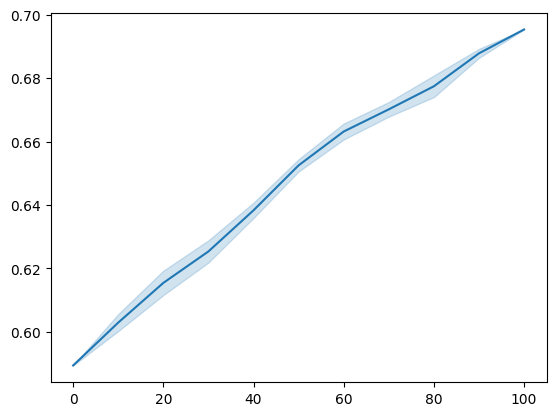

In [5]:
x = [10 * i for i in range(11)]
plt.figure()
plt.plot(x, mean_acc, color='C0')
plt.fill_between(x, mean_acc - std_acc, mean_acc + std_acc, color='C0', alpha=0.2)
plt.show()